In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from read_fk_table import get_fk_table
from read_faserv_pdf import read_pdf
from read_LHEF import read_LHEF_data
from data_errors import compute_errors
from MC_data_reps import generate_MC_replicas
from postfit_criteria import Postfit
from form_loss_fct import complete_loss_fct, raw_loss_fct
from postfit_measures import Measures
from logspace_grid import generate_grid

/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/read_fk_table.py:19: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep="\s+", header=None)


In [2]:
# Define global variables
# num_obs = 3 #between 1 and 4
REPLICAS  = 2

#HYPERPARAMETERS
lag_mult_pos = 1e-7
# x_integrability = np.array((1e-6,1e-5,1e-7,1,1.1,1.2))
x_integrability = np.array((2))
x_integrability = torch.tensor(x_integrability, dtype=torch.float32).view(-1,1)
integrability = True
positivity = True
preproc = 0
l1 = 20
l2 = 40
l3 = 20
lag_mult_pos = 1e-7
lag_mult_int = 1
fit_level = 2
lr = 0.001
max_counter = 100
max_Nepochs = 4500

In [3]:
pdf = "faserv"
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
faser_pdf,x_faser = read_pdf(pdf,x_vals)

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


In [4]:
class SimplePerceptron(torch.nn.Module):
    def __init__(self, l1,l2,l3):
        super(SimplePerceptron, self).__init__()
        self.linear = torch.nn.Linear(1,l1)
        self.hidden = torch.nn.Linear(l1,l2)
        self.hidden2 = torch.nn.Linear(l2,l3)
        self.hidden3 = torch.nn.Linear(l3,1)
        self.relu = torch.nn.ReLU()

    def forward(self, y):
        y = self.linear(y)
        y = self.relu(y)
        y = self.hidden(y)
        y = self.relu(y)
        y = self.hidden2(y)
        y = self.relu(y)
        y = self.hidden3(y)
    
        return y

In [5]:
import torch.nn as nn

if preproc == 0:
    class CustomPreprocessing(nn.Module):
        def __init__(self, alpha):
            super(CustomPreprocessing, self).__init__()
            self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
        def forward(self, x):
            return self.alpha*x
        
    class PreprocessedMLP(nn.Module):
        def __init__(self, alpha,l1, l2, l3):
            super(PreprocessedMLP, self).__init__()
            self.preprocessing = CustomPreprocessing(alpha)
            self.mlp = SimplePerceptron(l1, l2, l3)

        def forward(self, x):
            x = self.preprocessing(x)
            x = self.mlp(x)
            return x
        
if preproc == 1:
    class CustomPreprocessing(nn.Module):
        def __init__(self, alpha,beta,gamma):
            super(CustomPreprocessing, self).__init__()
            self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
            self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
            self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))

        def forward(self, x):
            return self.gamma*(1 - x) ** self.beta * x ** (1 - self.alpha) 
        
    class PreprocessedMLP(nn.Module):
        def __init__(self, alpha, beta, gamma,l1, l2, l3):
            super(PreprocessedMLP, self).__init__()
            self.preprocessing = CustomPreprocessing(alpha, beta,gamma)
            self.mlp = SimplePerceptron(l1, l2, l3)

        def forward(self, x):
            x = self.preprocessing(x)
            x = self.mlp(x)
            return x
        
if preproc == 2:
    class CustomPreprocessing(nn.Module):
        def __init__(self, alpha,beta,gamma,a,epsilon):
            super(CustomPreprocessing, self).__init__()
            self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
            self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
            self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))
            self.a = nn.Parameter(torch.tensor(a, dtype=torch.float32, requires_grad=True))
            self.epsilon = nn.Parameter(torch.tensor(epsilon, dtype=torch.float32, requires_grad=True))

        def forward(self, x):
            return self.a * x**(-self.alpha) * (1-x)**self.beta * (1+self.epsilon*x**0.5 + self.gamma*x)
        
    class PreprocessedMLP(nn.Module):
        def __init__(self, alpha, beta, gamma,a,epsilon,l1, l2, l3):
            super(PreprocessedMLP, self).__init__()
            self.preprocessing = CustomPreprocessing(alpha, beta,gamma,a,epsilon)
            self.mlp = SimplePerceptron(l1, l2, l3)

        def forward(self, x):
            x = self.preprocessing(x)
            x = self.mlp(x)
            return x
else:
    class CustomPreprocessing(nn.Module):
        def __init__(self, alpha):
            super(CustomPreprocessing, self).__init__()
            self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
        def forward(self, x):
            return self.alpha*x
        
    class PreprocessedMLP(nn.Module):
        def __init__(self, alpha,l1, l2, l3):
            super(PreprocessedMLP, self).__init__()
            self.preprocessing = CustomPreprocessing(alpha)
            self.mlp = SimplePerceptron(l1, l2, l3)

        def forward(self, x):
            x = self.preprocessing(x)
            x = self.mlp(x)
            return x

In [6]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,pred,
    data,
    cov_matrix,
    positivity,
    lag_mult_pos,
    integrability,
    x_integrability,
    y_integrability,):
        loss = complete_loss_fct(pred,
    data,
    cov_matrix,
    positivity,
    lag_mult_pos,
    integrability,
    x_integrability,
    y_integrability,)
        return loss

In [7]:
def perform_fit(pred,REPLICAS, x_alphas, cov_matrix,binwidths, fk_tables, mask, level1,x_alpha_more_bins  ):
    neutrino_pdfs,N_event_pred, arc_lenghts, chi_squares, int_penaltys,pos_penaltys  = [],[],[],[],[],[],
    for i in range(REPLICAS):
        if preproc == 0:
            alpha = 10
            model = PreprocessedMLP(alpha,l1, l2, l3)

        if preproc == 1:
            alpha,beta,gamma = -2.6,100,1000000
            model = PreprocessedMLP(alpha, beta, gamma,l1, l2, l3)

        if preproc == 2:    
            alpha,beta,gamma,epsilon, a= -1.5,26,1,2000,2000
            model = PreprocessedMLP(alpha, beta, gamma,a,epsilon,l1, l2, l3)
        else:
            alpha = 10
            model = PreprocessedMLP(alpha,l1, l2, l3)
            
        # Loss and optimizer
        criterion = CustomLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        pred[i] = pred[i].squeeze()

        model.train()

        best_loss = 1e13 # initial loss
        counter = 0
        num_epochs = 0

        while counter < max_counter:  
            if num_epochs>max_Nepochs:
                break 
            num_epochs+=1
            
            optimizer.zero_grad()

            y_pred =  model(torch.stack(x_alphas))
            y_preds = torch.matmul(fk_tables,y_pred)  * binwidths[:,None,None]
            y_preds = y_preds[mask]
            y_integrability =  model(x_integrability)
            loss,pos_penalty,*_ = criterion(y_preds, pred[i],cov_matrix, positivity,lag_mult_pos, integrability,x_integrability, y_integrability)
            loss.backward()
            optimizer.step()
            # print(loss)   

            if pos_penalty < 10**-6:
                if loss < best_loss:
                    best_loss = loss
                    counter = 0
                else:
                    counter +=1    
            else:
                counter +=1

        print(num_epochs) 
    
        loss, pos_penalty, int_penalty = criterion(y_preds, pred[i],cov_matrix, positivity,lag_mult_pos, integrability,x_integrability, y_integrability)
        red_chi_square_level1,*_ = criterion(y_preds, level1[0],cov_matrix, positivity,lag_mult_pos, integrability,x_integrability, y_integrability)

        print(f"reduced chi^2 level 2 = {loss}")
        print(f"reduced chi^2 level 1 = {red_chi_square_level1}")
        print(f"Constrained alpha: {model.preprocessing.alpha.item()}")
        # print(f"Constrained beta: {model.preprocessing.beta.item()}")
        # print(f"Constrained gamma: {model.preprocessing.gamma.item()}") 

        # print('max_alpha,min_alpha,max_beta,min_beta')
        # print(compute_effective_coeff(model))

        # save outcome of fit and its measures for postfit selection criteria
        closure_fit = Postfit()
        arc_lenghts.append(closure_fit.compute_arc_length(model))
        chi_squares.append(loss.detach().numpy())
        pos_penaltys.append(pos_penalty.detach().numpy())
        int_penaltys.append(np.sqrt(int_penalty.detach().numpy()))
        N_event_pred.append(y_preds.detach().numpy())
        cont_pred = model(x_alpha_more_bins).detach().numpy().flatten()
        neutrino_pdfs.append(cont_pred)
    return arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model



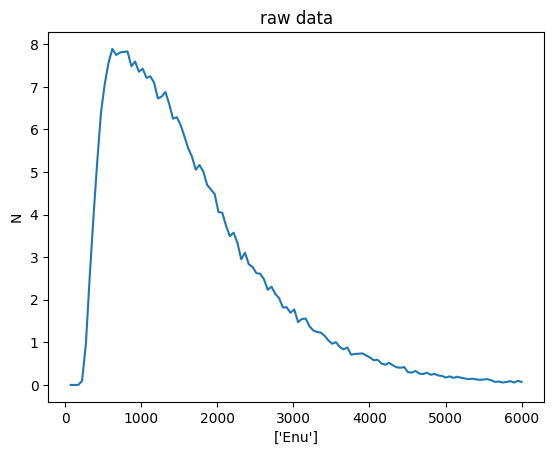

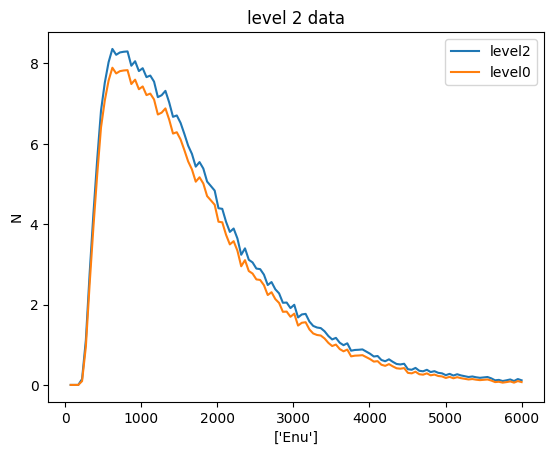

4501
reduced chi^2 level 2 = 0.006095383781939745
reduced chi^2 level 1 = 0.03008335642516613
Constrained alpha: 12.468037605285645
4501
reduced chi^2 level 2 = 0.011521818116307259
reduced chi^2 level 1 = 0.017392542213201523
Constrained alpha: 12.618616104125977
[array(0., dtype=float32), array(0., dtype=float32)]
[0.0015047342, 0.0014583915]
278.8288219484266 278.82882194842705
0.002713217 0.0027132172
278.8288219484275 278.82882194842705
0.0027132174 0.0027132172
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dattorch.Size([50])

faserv PDF set, member #0, version 1; LHAPDF ID = 50000001
delta chi^2 = 4.80051326751709
phi level 2 = -0.012882214970886707
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


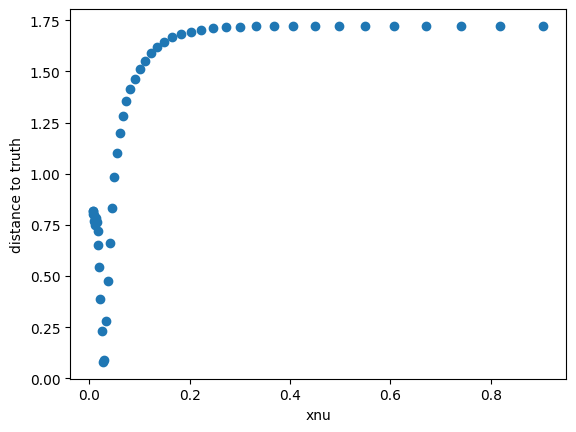

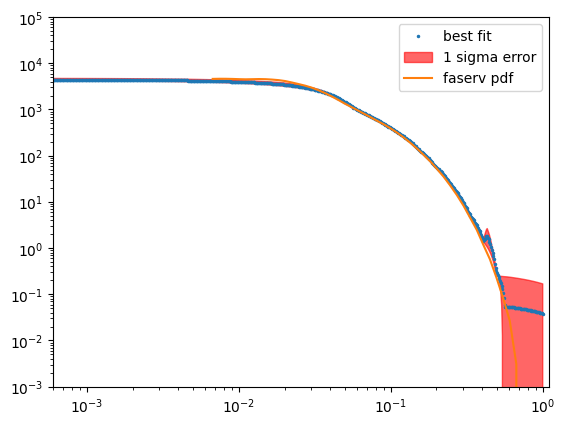

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_38492/972737202.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(x_faser,faser_pdf/faser_pdf,label ='faserv pdf')


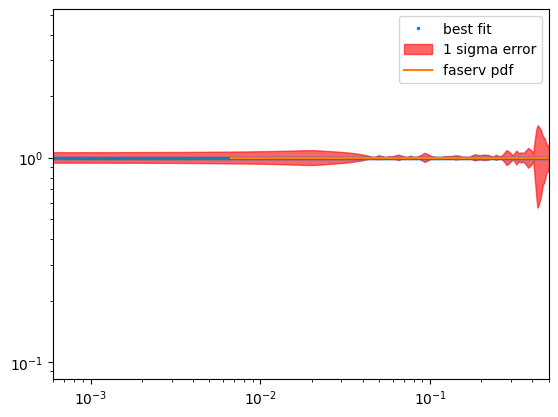

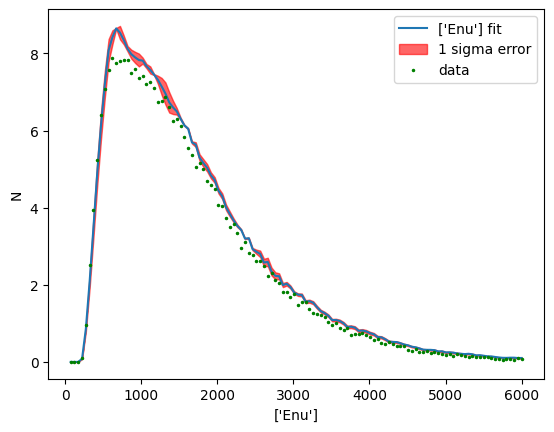

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_38492/972737202.py:113: RuntimeWarning: invalid value encountered in divide
  plt.plot(xvals_per_obs,mean_N_event_fit/mean_N_event_fit,label=f"{xlabels} fit")
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_38492/972737202.py:115: RuntimeWarning: invalid value encountered in divide
  plt.fill_between(xvals_per_obs,(mean_N_event_fit+sigma_N_event_fit)/mean_N_event_fit,(mean_N_event_fit-sigma_N_event_fit)/mean_N_event_fit,label='1 sigma error',color = 'red',alpha=0.6)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_38492/972737202.py:117: RuntimeWarning: invalid value encountered in divide
  plt.plot(xvals_per_obs,events_per_obs/events_per_obs,'go',label='data',markersize=1.5)


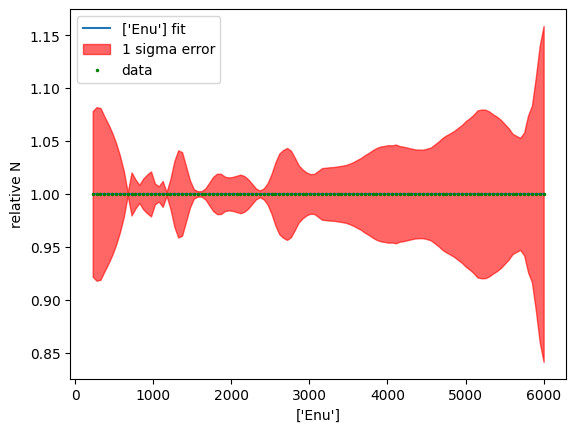

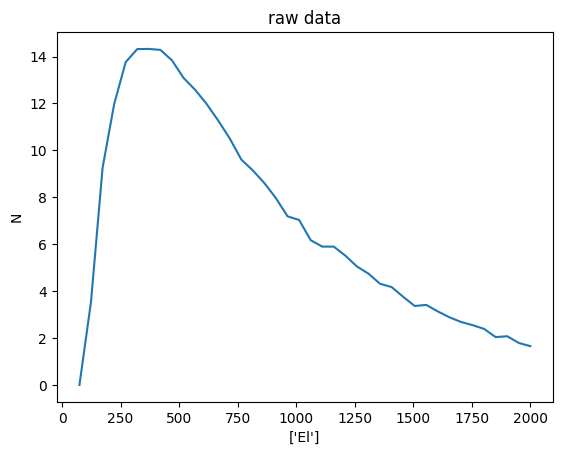

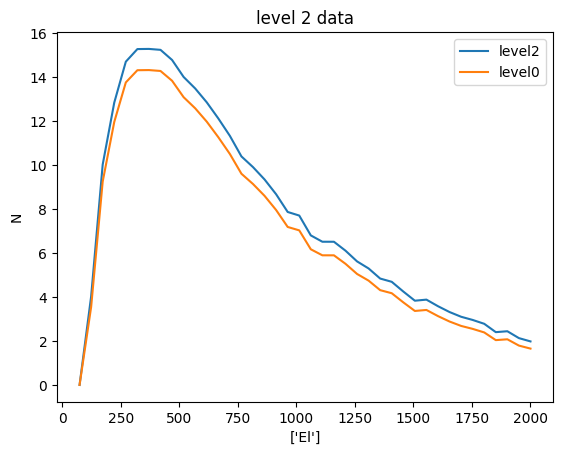

4501
reduced chi^2 level 2 = 0.00783561635762453
reduced chi^2 level 1 = 0.008489452302455902
Constrained alpha: 10.57671070098877
4501
reduced chi^2 level 2 = 0.021687014028429985
reduced chi^2 level 1 = 0.023847660049796104
Constrained alpha: 10.488999366760254
[array(0., dtype=float32), array(0., dtype=float32)]
[1.1920929e-06, 0.0005785376]
844.4179270148779 844.4179270148782
0.0069256993 0.006925699
844.4179270148784 844.4179270148782
0.0069256984 0.006925699
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dattorch.Size([50])

faserv PDF set, member #0, version 1; LHAPDF ID = 50000001
delta chi^2 = -0.8090315461158752
phi level 2 = -0.0772157683968544
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


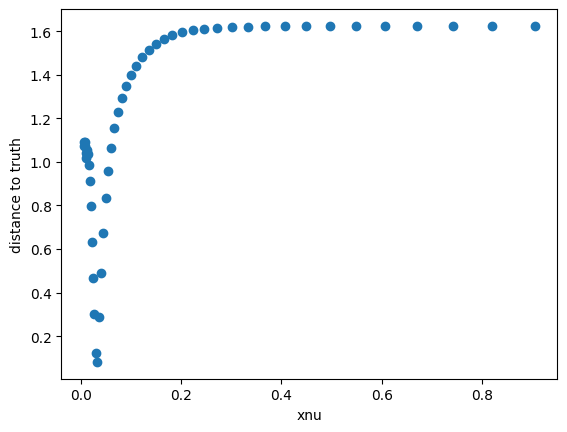

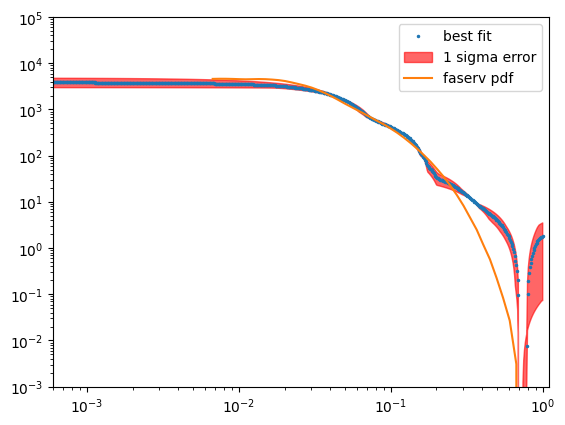

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_38492/972737202.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(x_faser,faser_pdf/faser_pdf,label ='faserv pdf')


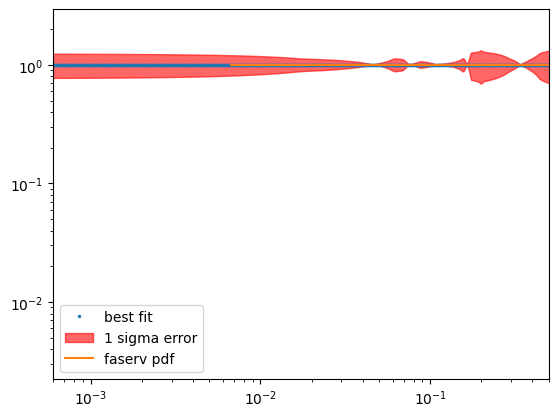

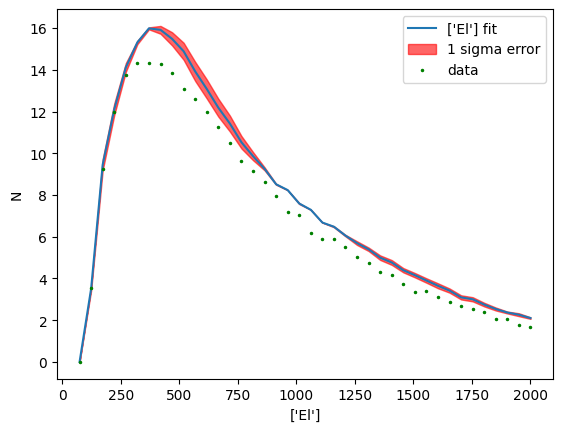

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_38492/972737202.py:113: RuntimeWarning: invalid value encountered in divide
  plt.plot(xvals_per_obs,mean_N_event_fit/mean_N_event_fit,label=f"{xlabels} fit")
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_38492/972737202.py:115: RuntimeWarning: invalid value encountered in divide
  plt.fill_between(xvals_per_obs,(mean_N_event_fit+sigma_N_event_fit)/mean_N_event_fit,(mean_N_event_fit-sigma_N_event_fit)/mean_N_event_fit,label='1 sigma error',color = 'red',alpha=0.6)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_38492/972737202.py:117: RuntimeWarning: invalid value encountered in divide
  plt.plot(xvals_per_obs,events_per_obs/events_per_obs,'go',label='data',markersize=1.5)


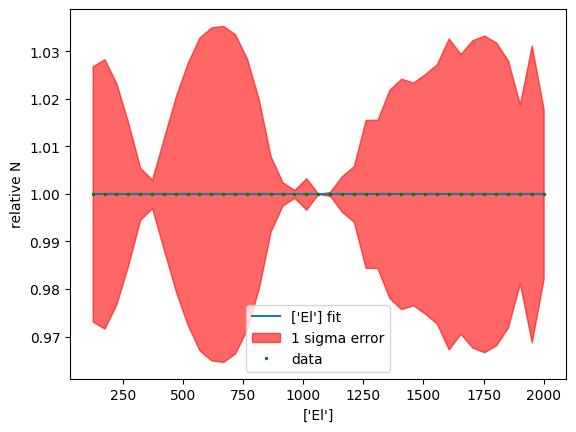

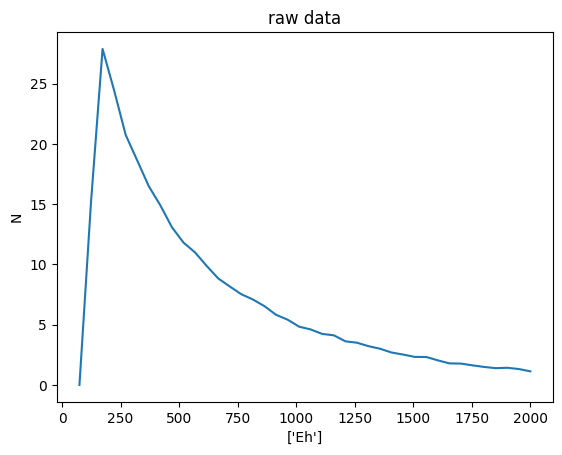

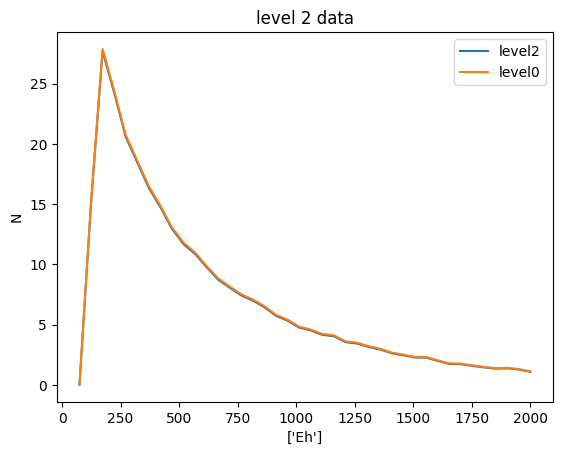

4501
reduced chi^2 level 2 = 0.021865785121917725
reduced chi^2 level 1 = 0.02254611626267433
Constrained alpha: 11.465968132019043
4501
reduced chi^2 level 2 = 0.25254684686660767
reduced chi^2 level 1 = 0.25153687596321106
Constrained alpha: 11.614273071289062
[array(0., dtype=float32), array(0., dtype=float32)]
[7.909536e-05, 0.011894494]
745.3206970261663 745.3206970261662
0.11534053 0.11534053
745.320697026166 745.3206970261662
0.11534053 0.11534053
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001
torch.Size([50])
delta chi^2 = 15.742685317993164
phi level 2 = 0.051827795803546906
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


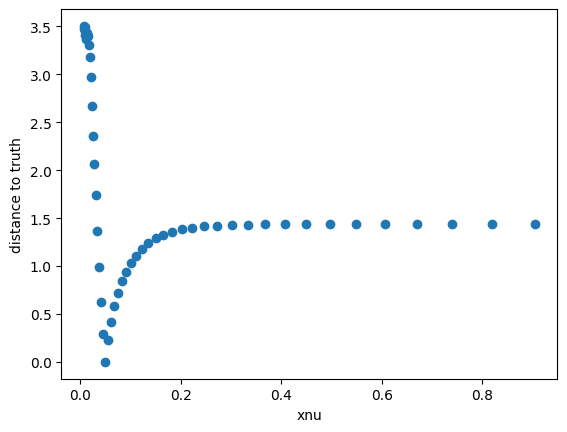

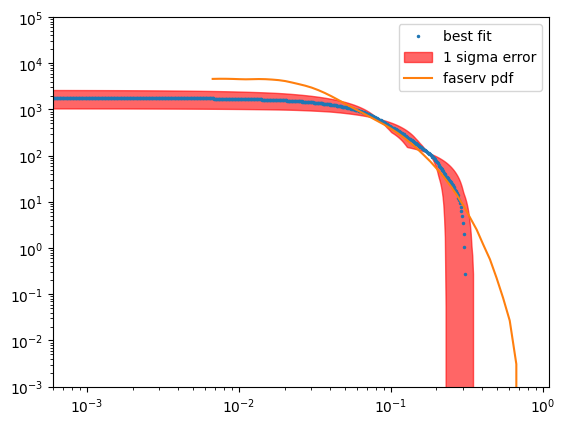

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_38492/972737202.py:84: RuntimeWarning: invalid value encountered in divide
  plt.plot(x_faser,faser_pdf/faser_pdf,label ='faserv pdf')


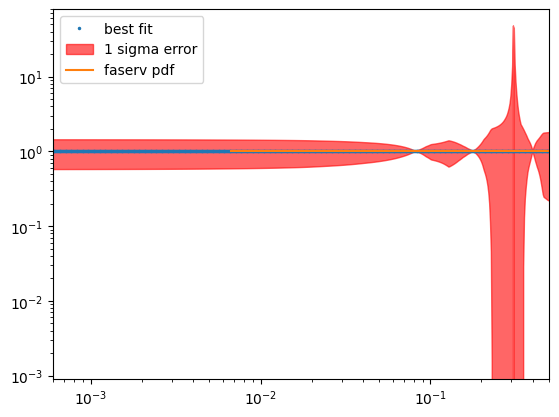

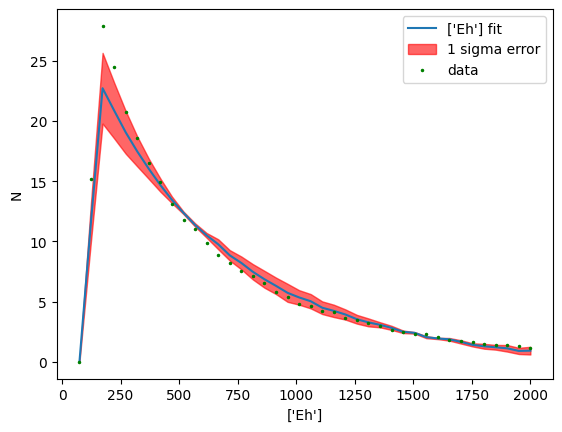

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_38492/972737202.py:113: RuntimeWarning: invalid value encountered in divide
  plt.plot(xvals_per_obs,mean_N_event_fit/mean_N_event_fit,label=f"{xlabels} fit")
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_38492/972737202.py:115: RuntimeWarning: invalid value encountered in divide
  plt.fill_between(xvals_per_obs,(mean_N_event_fit+sigma_N_event_fit)/mean_N_event_fit,(mean_N_event_fit-sigma_N_event_fit)/mean_N_event_fit,label='1 sigma error',color = 'red',alpha=0.6)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_38492/972737202.py:117: RuntimeWarning: invalid value encountered in divide
  plt.plot(xvals_per_obs,events_per_obs/events_per_obs,'go',label='data',markersize=1.5)


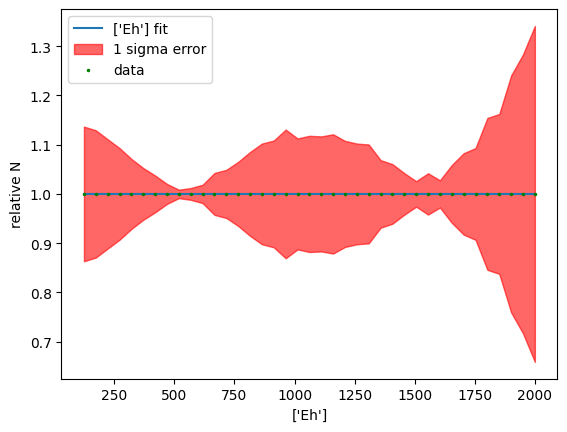

In [9]:
# Read data
num_obs = 3
for i in range(num_obs):
    data, data_min,data_max ,xvals_per_obs, binwidths,xlabels, events_per_obs =read_LHEF_data(i,i+1)
    xvals_per_obs = np.array(xvals_per_obs).flatten()
    events_per_obs = np.array(events_per_obs).flatten()
    #Get errors
    sig_sys,sig_tot, cov_matrix = compute_errors(data,data_min,data_max,1)    

    #Generate MC replicas of data
    level0,level1,level2 = generate_MC_replicas(REPLICAS,1,data,sig_sys)

    # Get FK tables
    x_alphas, fk_tables,mask = get_fk_table(i,i+1)

    plt.plot(xvals_per_obs,events_per_obs)
    plt.xlabel(xlabels)
    plt.ylabel('N')
    plt.title("raw data")
    plt.show()

    plt.plot(
        xvals_per_obs, level2[0], label="level2"
    )
    plt.plot(xvals_per_obs, events_per_obs,label="level0")
    plt.xlabel(xlabels)
    plt.legend()
    plt.ylabel("N")
    plt.title("level 2 data")
    plt.show()

    #Define variables for fit
    x_alpha_more_bins = np.logspace(-5,0,1000)
    x_alpha_more_bins = torch.tensor(x_alpha_more_bins, dtype=torch.float32).view(-1,1)
    if fit_level ==0:
        pred = level0
    if fit_level ==1:
        pred = level1
    if fit_level ==2:
        pred = level2
    
    arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(pred,REPLICAS, x_alphas, cov_matrix,binwidths, fk_tables, mask, level1,x_alpha_more_bins)

    closure_fit = Postfit()
    neutrino_pdfs, N_event_pred = closure_fit.apply_postfit_criteria(arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred,neutrino_pdfs)

    # Quantitative validation of PDF uncertainties in closure tests
    # theoretical prediction for # of events
    pdf = "faserv"
    lowx = -5
    n=50
    x_vals = generate_grid(lowx,n)

    postfit_measures = Measures(cov_matrix, pdf, N_event_pred)
    delta_chi = postfit_measures.compute_delta_chi(1, fk_tables, binwidths, mask, level1[0],x_vals)
    print(f'delta chi^2 = {delta_chi}')

    phi_chi_squared = postfit_measures.compute_phi(data, chi_squares)
    print(f'phi level 2 = {phi_chi_squared}')

    dist,xnu  = postfit_measures.compute_distance(neutrino_pdfs,x_vals)
    plt.plot(xnu,dist,'o')
    plt.ylabel('distance to truth')
    plt.xlabel('xnu')
    plt.show()

    cont_x = x_alpha_more_bins.detach().numpy().flatten()
    mean_neutrino_fit = np.mean(neutrino_pdfs,axis=0)
    error_neutrino_fit = np.std(neutrino_pdfs,axis=0) 
    plt.plot(cont_x,mean_neutrino_fit,'o',label="best fit",markersize=1.5)
    plt.fill_between(cont_x,mean_neutrino_fit+error_neutrino_fit,mean_neutrino_fit-error_neutrino_fit,label='1 sigma error',color = 'red',alpha=0.6)
    plt.plot(x_faser,faser_pdf,label ='faserv pdf')
    plt.ylim(10**-3,10**5)
    plt.xlim(6*10**-4,1.1)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('neutrino_fit.pdf')
    plt.show()

    plt.plot(cont_x,mean_neutrino_fit/mean_neutrino_fit,'o',label="best fit",markersize=1.5)
    plt.fill_between(cont_x,(mean_neutrino_fit+error_neutrino_fit)/mean_neutrino_fit,(mean_neutrino_fit-error_neutrino_fit)/mean_neutrino_fit,label='1 sigma error',color = 'red',alpha=0.6)
    plt.plot(x_faser,faser_pdf/faser_pdf,label ='faserv pdf')
    plt.xlim(6*10**-4,0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

    mean_N_event_fits = np.mean(N_event_pred,axis=0)
    sigma_N_event_fits = np.std(N_event_pred,axis=0)


    mean_N_event_fit = mean_N_event_fits
    sigma_N_event_fit = sigma_N_event_fits
    plt.plot(xvals_per_obs,mean_N_event_fit,label=f"{xlabels} fit")
    
    plt.fill_between(xvals_per_obs,(mean_N_event_fit+sigma_N_event_fit),(mean_N_event_fit-sigma_N_event_fit),label='1 sigma error',color = 'red',alpha=0.6)
    
    plt.plot(xvals_per_obs,events_per_obs,'go',label='data',markersize=1.5)

    plt.xlabel(f'{xlabels}')
    plt.ylabel('N')
    
    plt.legend()
    plt.show()


    mean_N_event_fit = mean_N_event_fits
    sigma_N_event_fit = sigma_N_event_fits
    
    plt.plot(xvals_per_obs,mean_N_event_fit/mean_N_event_fit,label=f"{xlabels} fit")
    
    plt.fill_between(xvals_per_obs,(mean_N_event_fit+sigma_N_event_fit)/mean_N_event_fit,(mean_N_event_fit-sigma_N_event_fit)/mean_N_event_fit,label='1 sigma error',color = 'red',alpha=0.6)
    
    plt.plot(xvals_per_obs,events_per_obs/events_per_obs,'go',label='data',markersize=1.5)

    plt.xlabel(f'{xlabels}')
    plt.ylabel('relative N')
    
    plt.legend()
    plt.show()

In [ ]:
def compute_accuracy():
    log_spaced = np.logspace(np.log10(1e-5), np.log10(0.1), 10)
    linear_spaced = np.linspace(0.1, 1, 10)
    x_xi_measure = np.concatenate((log_spaced, linear_spaced))
    x_xi_measure= torch.tensor(x_xi_measure, dtype=torch.float32).view(-1,1)

    pdf = "faserv"

    faser_pdf,x_faser = read_pdf(pdf,x_xi_measure)
    faser_pdf =faser_pdf.detach().numpy().squeeze()

    arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level1,REPLICAS=  1)
    mean_neutrino_pdf =model(x_xi_measure).detach().numpy().squeeze()
    
    return mean_neutrino_pdf,faser_pdf,n

mean_neutrino_pdf,faser_pdf,n = compute_accuracy()
xi = np.sum(abs(mean_neutrino_pdf-faser_pdf) < error_neutrino_fit)/ n
print(f'xi = {xi}')

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001
4501
reduced chi^2 level 2 = 0.057183604687452316
reduced chi^2 level 1 = 0.057183604687452316
Constrained alpha: 11.224266052246094
4501
reduced chi^2 level 2 = 0.010475926101207733
reduced chi^2 level 1 = 0.013609337620437145
Constrained alpha: 11.589882850646973
4501
reduced chi^2 level 2 = 0.02386259287595749
reduced chi^2 level 1 = 0.046930134296417236
Constrained alpha: 11.513642311096191
xi = 3.82


In [ ]:
def compute_bias_to_variance():
    # run more fits with a different level 1 shift
    # var is expected to be constant over the fits, so maybe just run 1 fit??: nog uitzoeken hoe dit computationeel effectief kan worden uitgevoerd
    pass